In [ ]:
import jax.numpy as jnp
from jax import grad, random, jit
from jax.example_libraries.optimizers import adam
from jax.scipy.special import logsumexp
from jax.nn import sigmoid, relu
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
size_data = 28
d_data = size_data * size_data # the dimension of a datapoint x
d_latent = 16 # the dimension of the hidden variables in the encoder/decoder
d_z = 2 # the dimension of the latent variable z
min_prob = 1e-6
max_prob = 1 - min_prob
epochs = 100

Upload `train.txt, train_label.txt, test.txt, test_label.txt, and anomaly.txt` to the Colab notebook using the "Upload to Session Storage" button in the files panel to the left.

In [ ]:
def loaddata():
    train = []
    test = []
    anomaly = []
    train_y = []
    test_y = []
    with open('train.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            ar = line.split()
            ar = [float(a) for a in ar]
            train.append(jnp.array(ar))
    with open('train_label.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            train_y.append(int(line))
    with open('test.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            ar = line.split()
            ar = [float(a) for a in ar]
            test.append(jnp.array(ar))
    with open('test_label.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            test_y.append(int(line))
    with open('anomaly.txt','r') as f:
        lines = f.readlines()
        for line in lines:
            ar = line.split()
            ar = [float(a) for a in ar]
            anomaly.append(jnp.array(ar))
    return train,train_y, test, test_y, anomaly

In [24]:
rng_key = random.PRNGKey(0)
ranges = [d_z*d_latent, d_latent, d_latent*d_data, d_data, d_latent*d_data, d_latent,d_z*d_latent,d_z]
ranges = np.cumsum(ranges)
d_parameters = ranges[-1]

In [ ]:
def v2par(v):
    w1 = jnp.reshape(v[:ranges[0]],(d_latent, d_z))
    b1 = jnp.reshape(v[ranges[0]:ranges[1]],(d_latent))
    w2 = jnp.reshape(v[ranges[1]:ranges[2]],(d_data, d_latent))
    b2 = jnp.reshape(v[ranges[2]:ranges[3]],(d_data))
    w3 = jnp.reshape(v[ranges[3]:ranges[4]],(d_latent, d_data))
    b3 = jnp.reshape(v[ranges[4]:ranges[5]],(d_latent))
    w4 = jnp.reshape(v[ranges[5]:ranges[6]],(d_z, d_latent))
    b4 = jnp.reshape(v[ranges[6]:],(d_z))
    return w1,b1,w2,b2,w3,b3,w4,b4

def par2v(w1,b1,w2,b2,w3,b3,w4,b4):
    res = jnp.append(w1, b1)
    res = jnp.append(res, w2)
    res = jnp.append(res, b2)
    res = jnp.append(res, w3)
    res = jnp.append(res, b3)
    res = jnp.append(res, w4)
    return jnp.append(res, b4)

In [ ]:
# estimate the elbo given x with a single sample of \epsilon
def f(z, w1, b1, w2, b2):
    return sigmoid(w2 @ relu(w1 @ z + b1) + b2)

def g(x, w3, b3, w4, b4):
    return w4 @ relu(w3 @ x + b3) + b4

def elbo_estimator(v, epsilon, x):
    w1,b1,w2,b2,w3,b3,w4,b4 = v2par(v)

    z = 0.1 * epsilon + g(x, w3, b3, w4, b4)
    res = -0.5 * z.T @ z
    res += 0.005 * (0.1 * epsilon).T @ (0.1 * epsilon)
    fz = jnp.clip(f(z, w1, b1, w2, b2), min_prob, max_prob)
    ber = x * jnp.log(fz) + (1 - x) * jnp.log(1 - fz)
    return res + np.sum(ber)


In [20]:
elbo_gradient = jit(grad(elbo_estimator,argnums=(0)))
train, train_y, test, test_y, anomaly = loaddata()

In [29]:
rng_key, key = random.split(rng_key)
v = 0.1 * random.normal(key, (d_parameters,)) # random initialization
init, update, get_params = adam(1e-3)
state = init(v) # the initial state of training, which includes not only v, but also some parameters for the optimizer
step = 0
elbo_per_epoch_train = np.zeros(epochs)
elbo_per_epoch_test = np.zeros(epochs)
for i in tqdm(range(epochs)):
    # train
    elbo_train_sum = 0
    for x in train:
        rng_key, key = random.split(rng_key)
        epsilon = random.normal(key, (d_z,)) # generate epsilon for this datapoint
        grad_v = elbo_gradient(v, epsilon, x) # evaluate the gradients
        state = update(step, -grad_v, state) # update the parameters. Since we are maximizing the ELBO, we reverse the gradients here
        step += 1
        v = get_params(state)
        elbo_train_sum += elbo_estimator(v, epsilon, x)

    # test
    v = get_params(state)
    elbo_test_sum = 0
    for sample in test:
      rng_key, key = random.split(rng_key)
      epsilon = random.normal(key, (d_z,))
      elbo_test_sum += elbo_estimator(v, epsilon, sample)

    elbo_per_epoch_train[i] = elbo_train_sum / len(train)
    elbo_per_epoch_test[i] = elbo_test_sum / len(test)

100%|██████████| 100/100 [38:41<00:00, 23.21s/it]


Text(0, 0.5, 'Average ELBO Value')

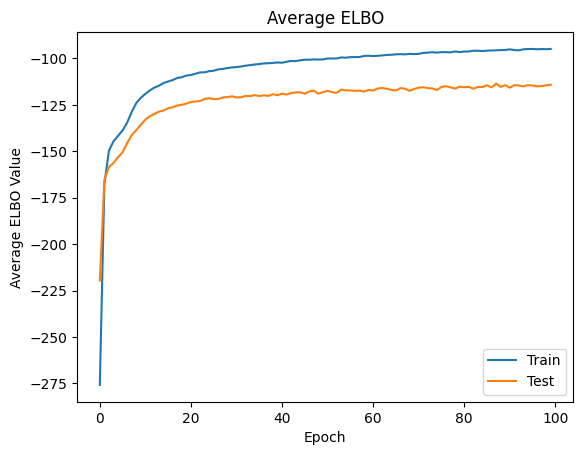

In [30]:
# Plot Solution
plt.figure()
plt.plot(range(epochs), elbo_per_epoch_train)
plt.plot(range(epochs), elbo_per_epoch_test)
plt.title("Average ELBO")
plt.legend(["Train","Test"])
plt.xlabel("Epoch")
plt.ylabel("Average ELBO Value")

In [31]:
v = get_params(state)
w1, b1, w2, b2, w3, b3, w4, b4 = v2par(v)

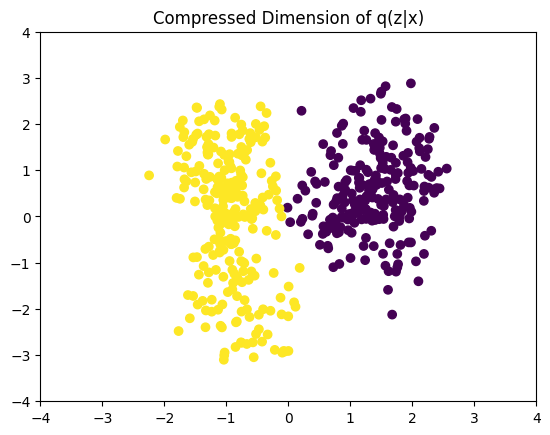

In [32]:
def plotCompressedData(compdata, complabels):
    compressedData = np.zeros((len(compdata),2))
    epsilon = random.normal(key, (d_z,))
    for i in range(len(compdata)):
      compressedData[i] = g(compdata[i], w3, b3, w4, b4)
    plt.figure()
    plt.scatter(compressedData[:, 0],compressedData[:,1], c = complabels)
    plt.xlim([-4,4])
    plt.ylim([-4,4])
    plt.title("Compressed Dimension of q(z|x)")

plotCompressedData(test,test_y)

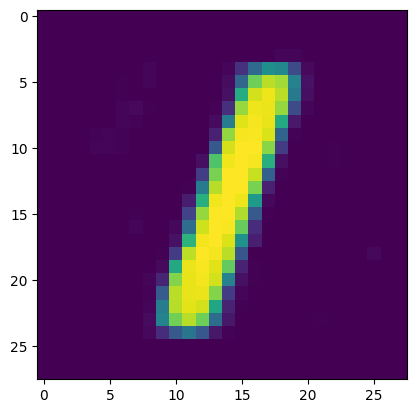

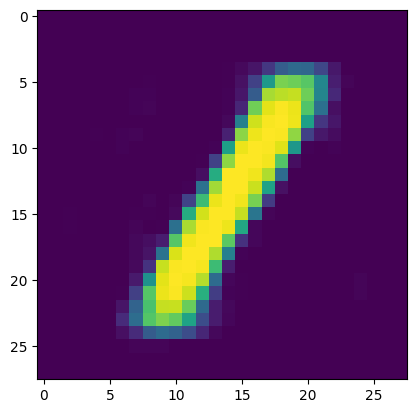

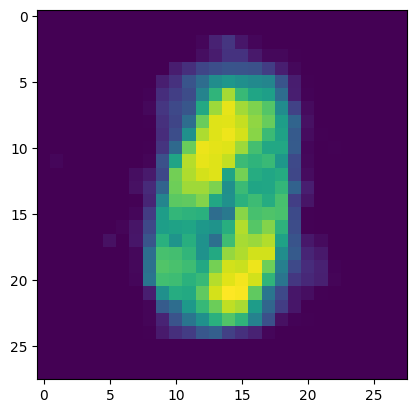

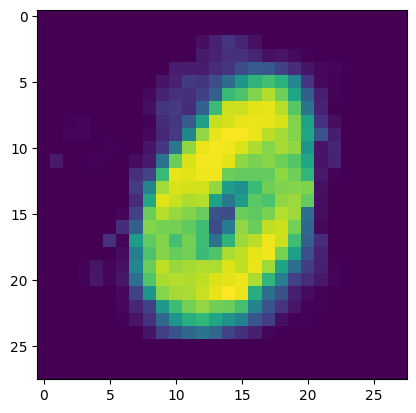

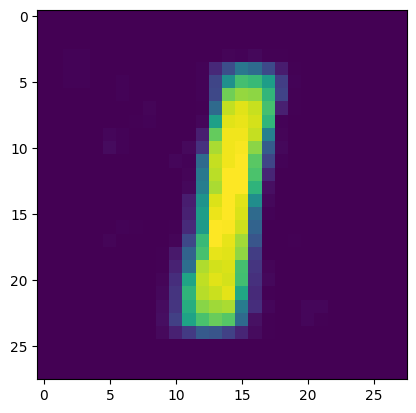

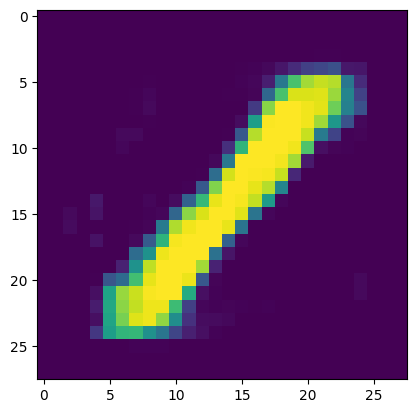

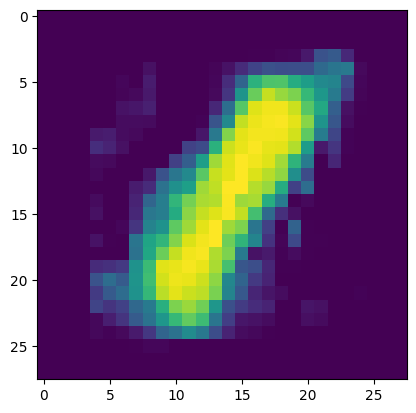

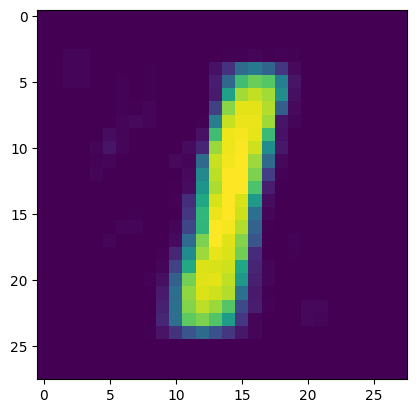

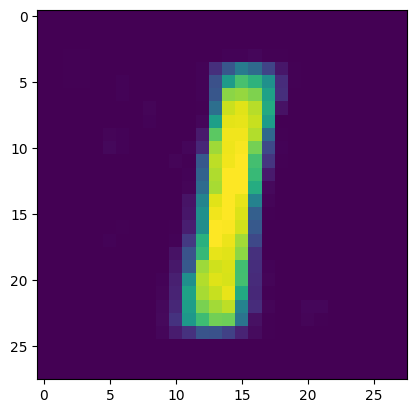

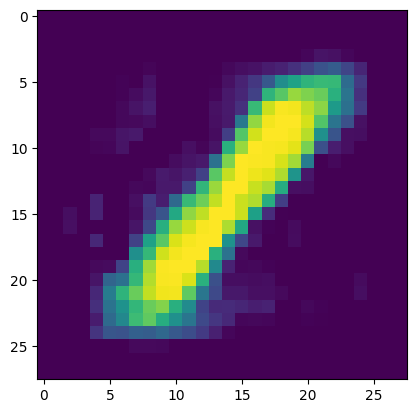

In [41]:
for im in range(10):
    rng_key, key = random.split(rng_key)
    z = random.normal(key, (d_z,))
    x = f(z, w1, b1, w2, b2)
    plt.figure(im)
    plt.imshow(x.reshape(28,28))


In [34]:
train_ll, test_ll = [], []
for x in tqdm(train):
  lls = []
  for _ in range(50):
    rng_key, key = random.split(rng_key)
    epsilon = random.normal(key, (d_z,))
    lls.append(elbo_estimator(v, epsilon, x))
  train_ll.append(logsumexp(np.array(lls)) - np.log(50))

for x in tqdm(test):
  lls = []
  for _ in range(50):
    rng_key, key = random.split(rng_key)
    epsilon = random.normal(key, (d_z,))
    lls.append(elbo_estimator(v, epsilon, x))
  test_ll.append(logsumexp(np.array(lls)) - np.log(50))

100%|██████████| 500/500 [02:15<00:00,  3.70it/s]


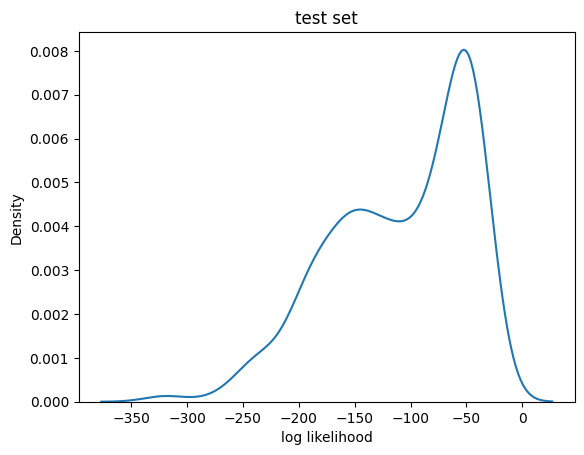

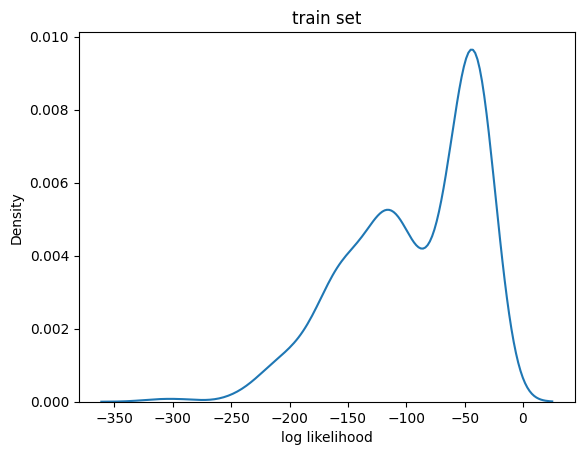

In [35]:
import seaborn as sns
plt.title('test set')
plt.xlabel('log likelihood')
fig = sns.kdeplot(np.array(test_ll))
plt.show()
plt.close()
plt.title('train set')
plt.xlabel('log likelihood')
fig = sns.kdeplot(np.array(train_ll))
plt.show()
plt.close()